In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import glob
import tifffile as tif

Fonctions

In [5]:
def compute_local_contrast(image, window_size=200):
    """Compute local contrast using local standard deviation."""
    kernel = np.ones((window_size, window_size), np.float32) / (window_size**2) # Create moving window
    
    local_mean = cv2.filter2D(image, -1, kernel) # Compute local mean
    local_mean_sq = cv2.filter2D(image ** 2, -1, kernel) # Compute local squared mean

    # Compute local variance (E[X^2] - (E[X])^2) and take sqrt for standard deviation
    local_stdev = np.sqrt(local_mean_sq - local_mean ** 2)
    return local_stdev


def low_pass_filter(shape, radius):
    """Create an ideal low-pass filter mask."""
    rows, cols = shape
    center = (rows // 2, cols // 2)
    mask = np.zeros((rows, cols), np.float32)
    for i in range(rows):
        for j in range(cols):
            if np.sqrt((i - center[0])**2 + (j - center[1])**2) <= radius:
                mask[i, j] = 1
    return mask


def high_pass_filter(shape, radius):
    """Create an ideal high-pass filter mask."""
    return 1 - low_pass_filter(shape, radius)


def hilo_reconstruction_contrasted(I_high, I_1, I_2, alpha=1.0, sigma=5, contrast_threshold=0.5):
    """ HiLo image reconstruction.
    Parameters:
    - I_high: uniform illumination.
    - I_1: checkerboard illumination.
    - I_2: inverted checkerboard illumination.
    - alpha: high-frequency contribution.
    - sigma: stdev for Gaussian filtering.
    - contrast_threshold: (NOT USED)
    Returns:
    - I_hilo: reconstructed HiLo image."""
    
    I_high = I_high.astype(np.float32)
    I_1 = I_1.astype(np.float32)
    I_2 = I_2.astype(np.float32)

    # Compute local contrast of checkerboard images
    local_contrast1 = compute_local_contrast(I_1)
    local_contrast2 = compute_local_contrast(I_2)
    # Normalize local contrast
    contrast_weight1 = cv2.normalize(local_contrast1, None, 0, 1, cv2.NORM_MINMAX)
    contrast_weight2 = cv2.normalize(local_contrast2, None, 0, 1, cv2.NORM_MINMAX)

    # Create a mask for in-focus regions based on local contrast (NOT USED)
    # mask1 = np.abs(local_contrast1) > contrast_threshold
    # mask2 = np.abs(local_contrast2) > contrast_threshold

    # Compute the low-frequency component as the average of checkerboard images (NOT USED)
    # I_low = (I_1 * mask1.astype(np.float32) + I_2 * mask2.astype(np.float32))  # Averaging method

    # Weighted averaging 
    epsilon = 1e-8  # Just in case, to avoid division by zero
    I_low = (I_1 * contrast_weight1 + I_2 * contrast_weight2) / (contrast_weight1 + contrast_weight2 + epsilon)

    # Gaussian Filtering
    I_low_filtered = cv2.GaussianBlur(I_low, (0, 0), sigma)
    I_high_filtered = I_high - cv2.GaussianBlur(I_high, (0, 0), sigma)

    # Fourier Filtering (NOT USED)
    #I_low_filtered = np.abs(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(I_low)) * low_pass_filter(I_low.shape, 30))))
    #I_high_filtered = I_high - np.abs(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(I_high)) * low_pass_filter(I_high.shape, 30))))

    # Combine high and low-freq components and normalize
    I_hilo = I_low_filtered + alpha * I_high_filtered
    I_hilo = cv2.normalize(I_hilo, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Display images for visualization
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.title("I_high")
    plt.imshow(I_high, cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title("I_high_filtered")
    plt.imshow(I_high_filtered, cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title("I_low_filtered")
    plt.imshow(I_low_filtered, cmap='gray')

    plt.subplot(1, 4, 4)
    plt.title("I_hilo")
    plt.imshow(I_hilo, cmap='gray')

    plt.show()

    return I_hilo


def hilo_reconstruction2(I_high, I_structured_list, alpha=1.0, sigma=5):
    """ 
    HiLo image reconstruction with multiple structured illumination images.
    Parameters:
    - I_high: uniform illumination image.
    - I_structured_list: list of structured illumination images (ex: speckles).
    - alpha: high-freq contribution factor.
    - sigma: stdev for Gaussian filtering.
    Returns:
    - I_hilo: reconstructed HiLo image. 
    """

    I_high = I_high.astype(np.float32)
    epsilon = 1e-8

    # Initialize weighted sum and weight total
    weighted_sum = np.zeros_like(I_high, dtype=np.float32)
    weight_total = np.zeros_like(I_high, dtype=np.float32)

    for I_struct in I_structured_list:
        I_struct = I_struct.astype(np.float32)
        local_contrast = compute_local_contrast(I_struct)
        contrast_weight = cv2.normalize(local_contrast, None, 0, 1, cv2.NORM_MINMAX)

        weighted_sum += I_struct * contrast_weight
        weight_total += contrast_weight

    # Calculate I_low
    I_low = weighted_sum / (weight_total + epsilon)

    # Apply Gaussian filtering
    I_low_filtered = cv2.GaussianBlur(I_low, (0, 0), sigma)
    I_high_filtered = I_high - cv2.GaussianBlur(I_high, (0, 0), sigma)

    # Combine components for HiLo image
    I_hilo = I_low_filtered + alpha * I_high_filtered
    I_hilo = cv2.normalize(I_hilo, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Display images for visualization
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.title("I_high")
    plt.imshow(I_high, cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title("I_high_filtered")
    plt.imshow(I_high_filtered, cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title("I_low_filtered")
    plt.imshow(I_low_filtered, cmap='gray')

    plt.subplot(1, 4, 4)
    plt.title("I_hilo")
    plt.imshow(I_hilo, cmap='gray')

    plt.show()

    return I_hilo, I_high, I_high_filtered, I_low_filtered

Reconstruction

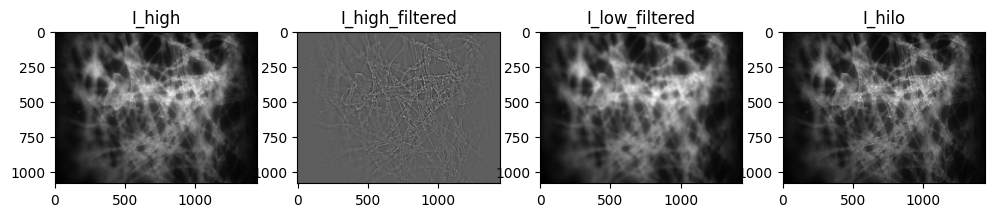

In [7]:
img_uniform = np.array(Image.open('D:/images_camera/papier_fluo_plain.tif').convert('L'))
img_check1 = np.array(Image.open('D:/images_camera/papier_fluo_check.tif').convert('L'))
img_check2 = np.array(Image.open('D:/images_camera/papier_fluo_check_inverted.tif').convert('L'))

I_hilo_contrast = hilo_reconstruction_contrasted(img_uniform, img_check1, img_check2, alpha=1.0, sigma=5, contrast_threshold=0.7)

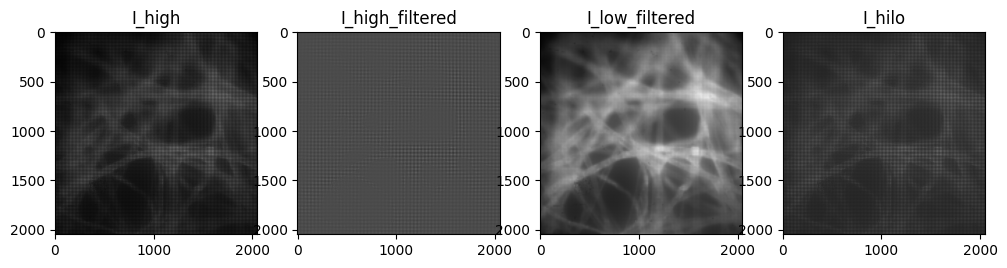

In [7]:
fichiers_tiff = sorted(glob.glob("D:/surgele/tests_0605/patterns/*.tiff"))
I_structured_list = [tif.imread(f) for f in fichiers_tiff]
img_uniform = tif.imread("D:/surgele/tests_0605/snap_plain.tiff")

hilo, _, _, _ = hilo_reconstruction2(img_uniform, I_structured_list)